In [16]:
import xml.etree.ElementTree as ET
from collections import Counter
from collections import defaultdict
import nltk
from glob import glob
from nltk import word_tokenize, sent_tokenize
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from collections import Counter
from ast import literal_eval
import json
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

tqdm().pandas()

To better get a sense of what potential the first NMT baseline model has, I collected sentences which Acrolinx flags as formal from our Microsoft Azure documents. I then put these sentences, tokenized, into a text file for OpenNMT to be able to process and test.

In [6]:
files = glob('data/Microsoft Results/*.xml')
assert len(files) == 9712

In [92]:
cd /home/rebekah/Documents/make-it-sound-less-formal

/home/rebekah/Documents/make-it-sound-less-formal


In [93]:
def flag_data(files):
    # takes list of file names
    # extracts flagged sentences
    # puts in new pandas dataframe, already tokenized
    
    guidelines = []
    sentences = []
    
    for idx in tqdm_notebook(range(len(files))):
        file = files[idx]
        tree = ET.parse(file)
        root = tree.getroot()
        body = tree.find('body')
        results = body.find('results')
        voice = results.find('voiceGuidance')
        flags = voice.find('listOfVoiceGuidanceFlags')
        
        for flag in flags:
            guideline = flag.get('name')     
            if 'conversationalTone' in guideline:
                context = flag.find('context').text
                if type(context) == str:
                    if len(context) > 0:
                        sents = sent_tokenize(context)
                        for sent in sents:
                            sentences.append((' ').join(word_tokenize(sent)))
                            guidelines.append(guideline)
    
    return pd.DataFrame(data={'guideline': guidelines, 'source': sentences})

In [94]:
ms_df = flag_data(files)

In [95]:
ms_df.iloc[1860]['source']

'If you want to log to a different destination than a Log Analytics workspace , use the appropriate parameters for an Azure Storage account or Event Hub .'

In [96]:
ms_df.to_pickle('data/microsoft_df.pkl')

In [97]:
def series_to_txt(series, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for item in series:
            f.write(item + '\n')
            
series_to_txt(ms_df['source'], 'data/microsoft_df.txt')

# check vocabulary vs. difficult word list from previously

In [36]:
% cd /home/rebekah/Documents/past\ tasks/2019-01\ word\ embeddings

/home/rebekah/Documents/past tasks/2019-01 word embeddings


In [37]:
ms_words = pd.read_excel('words_actual_final.xls')

In [38]:
ms_words.head()

,Unnamed: 0,words,3vote
0,0,pervasive,"['prevalent', 'widespread']"
1,1,intriguing,['interesting']
2,3,shutterbugs,['photographers']
3,4,caress,['kiss']
4,5,upbraided,['scolded']


In [39]:
% cd /home/rebekah/Documents/make-it-sound-less-formal

diff_words = list(ms_words['words'])

with open('data/diff_words.txt', 'w') as f:
    for word in diff_words:
        f.write(word + '\n')

/home/rebekah/Documents/make-it-sound-less-formal


In [40]:
diff_words = list(ms_words['words'])
simp_words_lists = list(ms_words['3vote'])
simp_words = []
for item in simp_words_lists:
    item = literal_eval(item)
    for word in item:
        simp_words.append(word)
sentences = list(ms_df['source'])

In [41]:
n = 0

for i in tqdm_notebook(range(len(sentences))):
    n += len(sentences[i].split())
    
print(n)


4714725


In [42]:
ms_vocab = Counter()

for i in tqdm_notebook(range(len(sentences))):
    ms_vocab.update(sentences[i].split())

print(len(ms_vocab))


47257


In [81]:
print('Number of difficult words: ' + str(len(diff_words)))
times = 0
counts = 0
for word in diff_words:
    if word in ms_vocab:
        times += 1
        counts += ms_vocab[word]
print('Unique difficult words which appear in corpus: ' + str(times))
print('Occurrences of difficult words in corpus: ' + str(counts))

Number of difficult words: 3791
Unique difficult words which appear in corpus: 585
Occurrences of difficult words in corpus: 55338


In [82]:
print('Number of simpler words: ' + str(len(simp_words)))
times = 0
counts = 0
for word in simp_words:
    if word in ms_vocab:
        times += 1
        counts += ms_vocab[word]
print('Unique simpler words which appear in corpus: ' + str(times))
print('Occurrences of simpler words in corpus: ' + str(counts))

Number of simpler words: 4132
Unique simpler words which appear in corpus: 1709
Occurrences of simpler words in corpus: 446287


# results

In [4]:
ms_df = pd.read_pickle('data/microsoft_df.pkl')
ms_df.head()

,guideline,source
0,guideline_conversationalTone_lexical,code-csharpTop-level declarations ]
1,guideline_conversationalTone_general,You can set up alerts to trigger an alert when...
2,guideline_conversationalTone_general,"For example , you might set up an alert for a ..."
3,guideline_conversationalTone_lexical,Azure IoT Hub provides the features and an ext...
4,guideline_conversationalTone_lexical,Devices range from constrained sensors and sin...


In [7]:
ms_pred_path = open('data/microsoft_df_pred.txt')
ms_pred = [line.rstrip() for line in ms_pred_path.readlines()]
del ms_pred_path

In [9]:
ms_df['target'] = ms_pred
ms_df.head()

,guideline,source,target
0,guideline_conversationalTone_lexical,code-csharpTop-level declarations ],Putin Hamm - you 'll know .
1,guideline_conversationalTone_general,You can set up alerts to trigger an alert when...,You can always put a little busy to lighten a ...
2,guideline_conversationalTone_general,"For example , you might set up an alert for a ...","For example , you might set up a matter of a s..."
3,guideline_conversationalTone_lexical,Azure IoT Hub provides the features and an ext...,Drown shui ( I 've got that ! )
4,guideline_conversationalTone_lexical,Devices range from constrained sensors and sin...,"Christy senthil , she 's single , but he is th..."


In [3]:
#ms_df.to_pickle('data/microsoft_df.pkl')
ms_df = pd.read_pickle('data/microsoft_df.pkl')

In [10]:
general = ms_df['guideline'] == "guideline_conversationalTone_general"

for idx, row in ms_df[general].sample(5).iterrows():
    #print('Guideline:\t' + row['guideline'])
    print('Source:\t\t' + row['source'])
    print('Target:\t\t' + row['target'])
    print()

Source:		This private IP address serves as an internal endpoint , accessible only to the resources within its virtual network and the remote networks connected to the virtual network .
Target:		It is the internal postal ... if you want the connections , the remote network the virtual network connection ...

Source:		For example , ffmpeg is a popular application that processes audio and video files .
Target:		Like , rhianna is a popular site that has to do that and video files .

Source:		Learn how to create a virtual network peering in other scenarios by clicking the scenario from the following table :
Target:		Then learn how to create a virtual network .

Source:		This quickstart demonstrates how to use the Query editor to connect to a SQL database , and then use Transact-SQL statements to query , insert , update , and delete data in the database .
Target:		Hey , this begs , how to use the answering and the hook up and get bk and ask .

Source:		Delete the preconfigured solution from 

In [11]:
ms_df[general]

,guideline,source,target
1,guideline_conversationalTone_general,You can set up alerts to trigger an alert when...,You can always put a little busy to lighten a ...
2,guideline_conversationalTone_general,"For example , you might set up an alert for a ...","For example , you might set up a matter of a s..."
23,guideline_conversationalTone_general,Azure IoT Hub provides the features and an ext...,Drown shui ( I 've got that ! )
24,guideline_conversationalTone_general,Devices range from constrained sensors and sin...,"Christy senthil , she 's single , but he is th..."
25,guideline_conversationalTone_general,"In addition , the use cases and requirements f...",And the use cases and the for for : the one fo...
26,guideline_conversationalTone_general,"Despite this variation , device management wit...","Not sagging , but , that 's the way it is , bu..."
49,guideline_conversationalTone_general,Most of the technical content that 's currentl...,I think that most of the stuff that is up with...
50,guideline_conversationalTone_general,It ’ s important for you to ensure that develo...,I do n't know what you mean about that .
124,guideline_conversationalTone_general,For a single Azure SQL database at a specific ...,"I think that is a pretty good thing for you , ..."
125,guideline_conversationalTone_general,The amount of resources is calculated as a num...,"You plum is the number of Database ( s ) , The..."


# evaluate using LexicalFormality.groovy / lf.json

In [2]:
% cd /home/rebekah/Documents/lingware/voice/EN/generic
lf_f = open('lf.json')
lf = json.loads(lf_f.read())
% cd /home/rebekah/Documents/make-it-sound-less-formal

/home/rebekah/Documents/lingware/voice/EN/generic
/home/rebekah/Documents/make-it-sound-less-formal


In [3]:
lf["have"]

-0.241125

In [4]:
ms_df = pd.read_pickle('data/microsoft_df.pkl')

In [6]:
def lf_score(sent):
    score = 0.0
    sent = word_tokenize(sent)
    if len(sent) == 0:
        return 0.0
    for word in sent:
        word = word.lower()
        if word in lf:
            score += lf[word]
    return score / len(sent)

In [7]:
ms_df['source_lf'] = ms_df['source'].apply(lf_score)
ms_df['target_lf'] = ms_df['target'].apply(lf_score)

In [13]:
ms_df['difference_lf'] = ms_df['source_lf'] - ms_df['target_lf']

In [17]:
pos = 0
neg = 0
for item in ms_df['difference_lf']:
    if item > 0.0:
        pos += 1
    else:
        neg += 1
print(pos)
print(neg)
print(ms_df['difference_lf'].mean())

217058
26595
0.07012073262751525


In [20]:
data_df = pd.read_pickle('data/rule_based_corrected_df.pkl')

In [21]:
data_df.head()

,Original,Target 0,Target 1,Target 2,Target 3,Category,Dataset
0,I mean that you have to really be her friend.,And I mean Really be her friend.,Just be her BFF 4 real.,you have to be her friend.,"You have to actually be her friend, for real.",Family_Relationships,test
1,Are you posing a rhetorical question?,Sounds like a rhetorical question :),Do you really want an answer?,That sounds more like a rhetorical question th...,Are you asking me a rhetorical question?,Family_Relationships,test
2,Men pretend to love in order to have intercour...,"Men play at love to get sex, women play at sex...","Men fake love to get laid, women fake orgasms ...","Guys PRETEND to love so they can get laid, wom...",Dudes just act like they love a chick to get b...,Family_Relationships,test
3,I do not intend to be mean.,I don't want to be mean.,I wasn't trying to be a jerk.,I'm not tryin to be mean...,I didn't want to be mean,Family_Relationships,test
4,I would estimate an average of 45% initially b...,On average I'd say about 45% at first but than...,"It's a little less than 50/50 at the start, bu...",Prolly 45% at the start but when you get to no...,"I guess it'd be around 45% to start with, but ...",Family_Relationships,test


# Original Test Results - Yahoo/Grammarly Corpus

In [3]:
v1_results = pd.read_pickle('data/v1_results.pkl')
v1_results.head()

,Source,Target,Prediction,source_lf,target_lf,pred_lf,src_tgt_diff,src_pred_diff
0,I mean that you have to really be her friend .,And I mean Really be her friend .,I mean you have to really be her friend .,-0.270857,-0.271620,-0.275536,0.000763,0.004680
1,Are you posing a rhetorical question ?,Sounds like a rhetorical question : ),What kind of question is that ?,-0.142981,-0.178207,-0.207015,0.035226,0.064035
2,Men pretend to love in order to have intercour...,"Men play at love to get sex , women play at se...","Men play love to have sex , women play for sex...",-0.195864,-0.237748,-0.216562,0.041885,0.020698
3,I do not intend to be mean .,I do n't want to be mean .,I do n't mean to be mean .,-0.204783,-0.242434,-0.219974,0.037651,0.015191
4,I would estimate an average of 45 % initially ...,On average I 'd say about 45 % at first but th...,"I would say a 15 % of 45 % , then once you get...",-0.126478,-0.218232,-0.182693,0.091754,0.056215


In [37]:
(v1_results['target_lf'] - v1_results['pred_lf']).mean()

0.0037219285105388623

In [5]:
print('source mean\t' + str(v1_results['source_lf'].mean()))
print('target mean\t' + str(v1_results['target_lf'].mean()))
print('pred mean\t' + str(v1_results['pred_lf'].mean()))

source mean	-0.1929587117844086
target mean	-0.21457392323635174
pred mean	-0.2182958517468906


In [6]:
v1_results.describe()

,source_lf,target_lf,pred_lf,src_tgt_diff,src_pred_diff
count,2101.000000,2101.000000,2101.000000,2101.000000,2101.000000
mean,-0.192959,-0.214574,-0.218296,0.021615,0.025337
std,0.049317,0.049389,0.049284,0.050025,0.043023
min,-0.334820,-0.487374,-0.349154,-0.200219,-0.164760
25%,-0.227958,-0.247298,-0.252729,-0.010516,0.000000
50%,-0.196117,-0.216134,-0.221436,0.017337,0.018918
75%,-0.159032,-0.183738,-0.188376,0.050733,0.048430
max,-0.009247,-0.032307,0.000000,0.256473,0.269680


In [30]:
print('target')
pos = 0
neg = 0
for item in v1_results['src_tgt_diff']:
    if item > 0.0:
        pos += 1
    else:
        neg += 1
print(pos)
print(neg)
print(v1_results['src_tgt_diff'].mean())

target
1390
711
0.021615211451943134


In [31]:
print('pred')
pos = 0
neg = 0
for item in v1_results['src_pred_diff']:
    if item > 0.0:
        pos += 1
    else:
        neg += 1
print(pos)
print(neg)
print(v1_results['src_pred_diff'].mean())

pred
1455
646
0.02533713996248199


## t-tests between LF for src and LF for tgt/pred

In [8]:
stats.levene(v1_results['source_lf'], v1_results['target_lf'])

LeveneResult(statistic=2.1204569180904063, pvalue=0.14541792381911198)

In [9]:
stats.levene(v1_results['source_lf'], v1_results['pred_lf'])

LeveneResult(statistic=1.3962904278215476, pvalue=0.23741256319784487)

In [10]:
stats.levene(v1_results['pred_lf'], v1_results['target_lf'])

LeveneResult(statistic=0.07611743352092658, pvalue=0.7826431473626729)

P = 0.05<br>
P-value is not significant, meaning there is homogeneity of variance between all results

In [25]:
def plot_pp(col):
    # adapted from http://scientificpythonsnippets.com/index.php/2-uncategorised/6-q-q-plot-in-python-to-test-if-data-is-normally-distributed
    data = list(v1_results[col])
    data.sort()
    norm = np.random.normal(0,2,len(data))
    norm.sort()

    plt.plot(norm,data,"o")

    #generate a trend line as in http://widu.tumblr.com/post/43624347354/matplotlib-trendline
    z = np.polyfit(norm,data, 1)
    p = np.poly1d(z)
    plt.plot(norm,p(norm),"k--", linewidth=2)
    plt.title(col)
    plt.xlabel("theoretical distribution")
    plt.ylabel("actual distribution")
    plt.tick_params()
    plt.show()

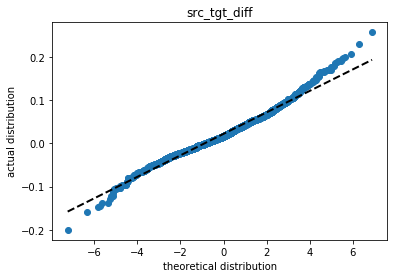

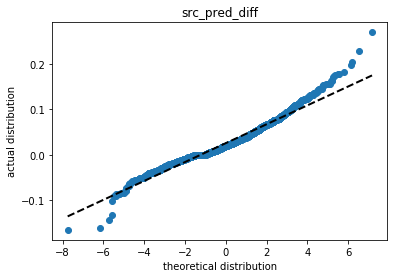

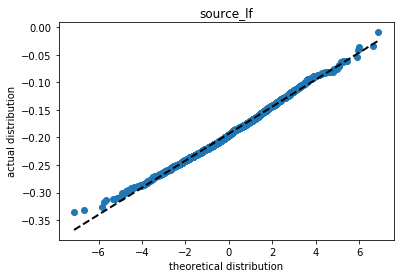

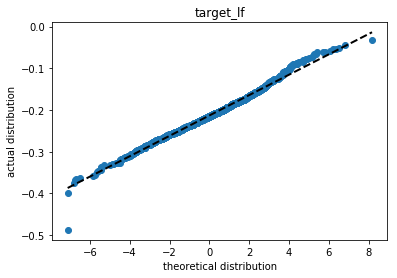

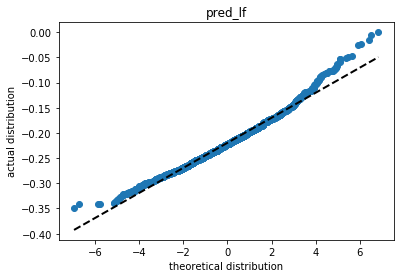

In [27]:
plot_pp('src_tgt_diff')
plot_pp('src_pred_diff')
plot_pp('source_lf')
plot_pp('target_lf')
plot_pp('pred_lf')

In [32]:
print(stats.shapiro(v1_results['src_tgt_diff']))
print(stats.shapiro(v1_results['src_pred_diff']))

(0.9852210283279419, 6.217566744662686e-14)
(0.9621561169624329, 5.191658331416489e-23)


Looks like residuals are normally distributed by the graphs, but the Shapiro stat produces a significant p-value

In [33]:
stats.ttest_ind(v1_results['source_lf'], v1_results['target_lf'])

Ttest_indResult(statistic=14.195253623192706, pvalue=1.0441501457556802e-44)

In [34]:
stats.ttest_ind(v1_results['source_lf'], v1_results['pred_lf'])

Ttest_indResult(statistic=16.657289197946156, pvalue=2.230917320422281e-60)

In [35]:
stats.ttest_ind(v1_results['pred_lf'], v1_results['target_lf'])

Ttest_indResult(statistic=-2.4450996634924658, pvalue=0.014522015014910234)

Looks like the LF score between the source and the target, and the source and the predicted output, carries a difference that is statistically significant.<br>

On the other hand the p-value for the pred and target values is much higher (less certain to be statistically significant, although still less than the preset value of p=0.05) which is to be expected as the pred aims to emulate target.